In [1]:
# General approach: 
    # News Texts: Sentences -> tokenize -> pad/truncate
    # Labels: already in 0,1
# LSTM
    # Vector Embedding layer (each work = n-dimensional vector)
    # Bi-directional LSTM with return_sequence True -> another Bi-directional LSTM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

### Load Data

In [3]:
train_df = pd.read_csv('../../Github/python-data-science/data/fake_news/train_data.csv', index_col='id')
test_df = pd.read_csv('../../Github/python-data-science/data/fake_news/test_data.csv', index_col='id')

In [4]:
print(train_df.shape, test_df.shape)

(72032, 3) (5200, 3)


In [5]:
new_df = train_df.append(test_df)
new_df.shape

(77232, 3)

In [6]:
new_df = new_df[['text', 'label']]
new_df['text'].isna().sum()

45

In [7]:
new_df = new_df.dropna()  # non-english articles
new_df.shape

(77187, 2)

In [8]:
train_df, test_df, _ , _ = train_test_split(new_df, new_df['label'], test_size=0.2, stratify=new_df['label'], random_state=12)
print(train_df.shape, test_df.shape)

(61749, 2) (15438, 2)


In [9]:
train_df['label'].value_counts(), test_df['label'].value_counts()

(0    40208
 1    21541
 Name: label, dtype: int64,
 0    10052
 1     5386
 Name: label, dtype: int64)

In [10]:
train_df.head()

,text,label
id,,
1352,"A week ago, it would have seemed wildly unlike...",0
25683,A group known in Arizona for assisting illegal...,1
17971,BEIRUT (Reuters) - Islamic State took control ...,1
1774,"LONDON — Joe Corré, the son of Malcolm McLa...",0
10332,Vickie Paladino and her husband were driving t...,0


In [11]:
test_df.head()

,text,label
id,,
17066,Show biz: Business and breakthroughs Exclusive...,0
11255,(Reuters) - President Barack Obama knocked Rep...,1
16441,AMSTERDAM (Reuters) - King Willem-Alexander on...,1
11724,https://www.youtube.com/watch?v=rUr8pYr5AXs,0
11376,"Elly Warren, from Melbourne, was travelling Af...",0


In [12]:
X_train = train_df['text']
y_train = train_df['label']
X_test  = test_df['text']
y_test  = test_df['label']

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(61749,) (61749,)
(15438,) (15438,)


In [14]:
# Expanding Dimension of X data: # No. rows x No. features 
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print(X_train.shape, X_test.shape)

(61749, 1) (15438, 1)


### Train/ Validation Split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=12)
print(X_train.shape, X_val.shape)

(43224, 1) (18525, 1)


In [16]:
y_train.value_counts(), y_val.value_counts()

(0    28240
 1    14984
 Name: label, dtype: int64,
 0    11968
 1     6557
 Name: label, dtype: int64)

### Text Vectorization

In [17]:
# textvectorizer = TextVectorization(max_tokens=10000, 
#                                    output_mode='int',
#                                    output_sequence_length=250)

# # Computes a vocabulary of string terms from tokens in a dataset
# textvectorizer.adapt(X_train) 

In [18]:
# str(X_train[0])[0:1000]

In [19]:
# X_train_vec = textvectorizer(X_train)
# X_val_vec   = textvectorizer(X_val)
# X_test_vec  = textvectorizer(X_test)

# print(X_train_vec.shape, X_val_vec.shape, X_test_vec.shape)

In [20]:
# X_train_vec[0]

### Tokenizer

In [21]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

In [22]:
tokenizer.fit_on_texts([i[0] for i in X_train])

In [23]:
X_train[0,0][0:300], tokenizer.texts_to_sequences(X_train[0])[0][:20]

('HAVANA (Reuters) - Cuba s foreign minister and his North Korean counterpart rejected the United States   unilateral and arbitrary  demands on Wednesday while expressing concern about escalating tensions on the Korean peninsula, the ministry said. North Korea is searching for support amid unprecedent',
 [6316,
  152,
  1844,
  18,
  212,
  326,
  5,
  21,
  225,
  1408,
  5703,
  1881,
  2,
  97,
  83,
  7097,
  5,
  9800,
  2508,
  11])

[ 493.  620.  815. 1164. 1478.]


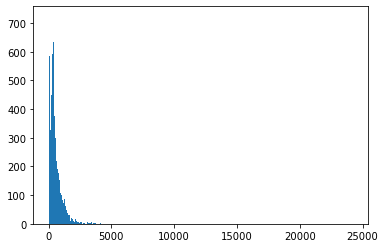

In [24]:
lengths = [len(t[0].split(' ')) for t in X_train]
print(np.quantile(lengths, [0.6, 0.7, 0.8, 0.9, 0.95]))
plt.hist(lengths, bins=len(set(lengths)));

In [25]:
maxlen = 500

def get_sequences(tokenizer, text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [26]:
X_train_vec = get_sequences(tokenizer, X_train[:,0])
X_train_vec.shape

(43224, 500)

In [27]:
X_val_vec = get_sequences(tokenizer, X_val[:,0])
X_test_vec = get_sequences(tokenizer, X_test[:,0])

print(X_val_vec.shape, X_test_vec.shape)

(18525, 500) (15438, 500)


In [28]:
print(len(X_test[250][0].split(' ')))
X_test_vec[250]

401


array([ 459,   16,    1,    1, 4077,    3,    1, 3369,    2, 1562,    8,
          2,  391,  992,   88,   23,  107,    1,   55,   36,   23,  107,
       2948,   12,   18,    6, 2948, 1592,    2, 1579,   49,  129,  990,
         11,    3, 3369,    2, 1562,   56,    6, 3624,  384,  117,  105,
         24,    9,   13,  955,   88, 1748,    3,   38,  366,    1,    4,
        258,    7,   30,  126,   13, 5796,    3,   38,  106, 1080, 2466,
          5,   38,  106, 1080,    1,    5, 2266,    5,    8,  729,   10,
         80,  459,  134,    6,  108,  643,    7,  623,    4,  163, 1816,
        108, 5157,    1,    1,  242,   24,  239,   13,   25,  107,    1,
         39, 1274,    6,  212,   87,    3, 3729,   79,    6,  283,    4,
       2983,   18,    7,   30,  126,   60,   24,   17,   13, 2494,  173,
         42,  429,   45,  461,   29,  115,   67,   43,    2, 1669, 4866,
         37,  147,   56, 1843,  166,   45, 6374,    8,    6,  443,    7,
         72,   87, 4751,  115,   67,  150,   18,   

### Model

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 128, mask_zero=True),  #input_length=maxlen),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, padding='valid', activation='selu', strides=2),
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='selu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [30]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer= 'adam', # tf.keras.optimizers.SGD(learning_rate=.0001), #'adam',
    metrics = ['accuracy']
)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, None, 20)          6800      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                        

In [32]:
h = model.fit(X_train_vec, y_train,
              validation_data=(X_val_vec, y_val),
              epochs=10, 
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)]
             )

Epoch 1/10
1351/1351 [==============================] - 103s 74ms/step - loss: 0.2575 - accuracy: 0.8986 - val_loss: 0.1865 - val_accuracy: 0.9405
Epoch 2/10
1351/1351 [==============================] - 99s 73ms/step - loss: 0.1332 - accuracy: 0.9519 - val_loss: 0.1590 - val_accuracy: 0.9461
Epoch 3/10
1351/1351 [==============================] - 102s 76ms/step - loss: 0.0810 - accuracy: 0.9711 - val_loss: 0.1771 - val_accuracy: 0.9421
Epoch 4/10
1351/1351 [==============================] - 105s 78ms/step - loss: 0.0512 - accuracy: 0.9836 - val_loss: 0.2160 - val_accuracy: 0.9310
Epoch 5/10
1351/1351 [==============================] - 108s 80ms/step - loss: 0.0336 - accuracy: 0.9898 - val_loss: 0.2428 - val_accuracy: 0.9345
Epoch 6/10
1351/1351 [==============================] - 106s 79ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.4501 - val_accuracy: 0.9392
Epoch 7/10
1351/1351 [==============================] - 108s 80ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.

In [33]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

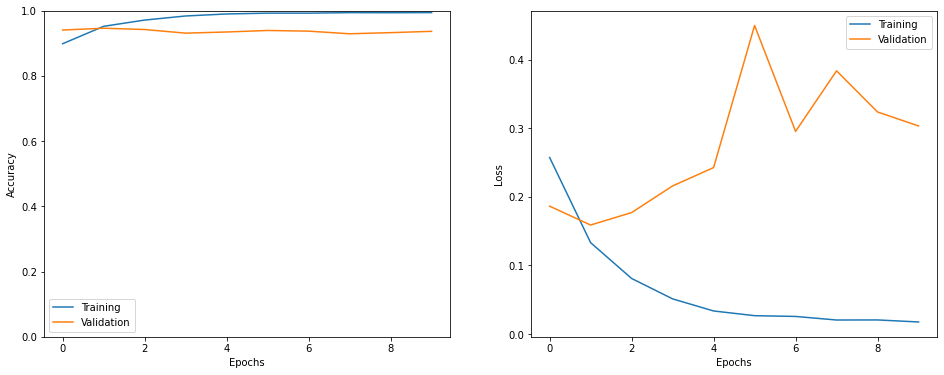

In [34]:
show_history(h)

In [35]:
y_pred = model.predict(X_test_vec)

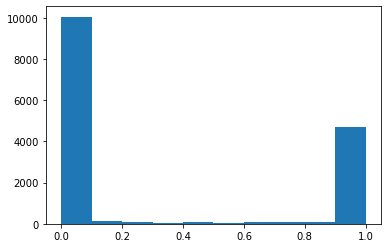

In [36]:
plt.hist(y_pred);

In [37]:
y_class = np.round(y_pred)

In [38]:
confusion_matrix(y_test, y_class)

array([[9748,  304],
       [ 683, 4703]], dtype=int64)

In [39]:
print('Accuracy score: {:.2f}%'.format(accuracy_score(y_test, y_class)*100))

Accuracy score: 93.61%


### BASELINE: TF-IDF (Term Frequency - Inverse Document Frequency)

In [40]:
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')
X_train_tfidf = tfidf.fit_transform(X_train[:,0])
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [42]:
X_test_tfidf = tfidf.transform(X_test[:,0])

### Fitting Out-of-Box Classifiers - PAC, Logistic, Random Forest

In [43]:
def show_results(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print('Accuracy score: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
    print(confusion_matrix(y_test, y_pred))

In [44]:
show_results(PassiveAggressiveClassifier(max_iter=50))

Accuracy score: 91.91%
[[9537  515]
 [ 734 4652]]


In [45]:
show_results(LogisticRegression(max_iter=500))

Accuracy score: 92.94%
[[9742  310]
 [ 780 4606]]


In [46]:
show_results(RandomForestClassifier(n_jobs=-1))

Accuracy score: 91.45%
[[9758  294]
 [1026 4360]]
